# Forecast Experiments - Moving Window Solution

* I will use the latest 2,3 weeks data as the training data, to see how moving window forecast would work.
* Quite different from the fixed window solution, here the whole piece of historical will be divided into sequences, 2 or 3 weeks for training data, 1 week for testing data, and the new testing data will be part of the next training data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import itertools
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [3]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean().dropna()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean().dropna()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean().dropna()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean().dropna()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(97,) (97,) (11,) (7,)


purchase_date
2019-05-25    3.748604
2019-05-26    3.671921
2019-05-27    3.625118
2019-05-28    3.512122
2019-05-29    3.391662
Name: client_count, dtype: float64

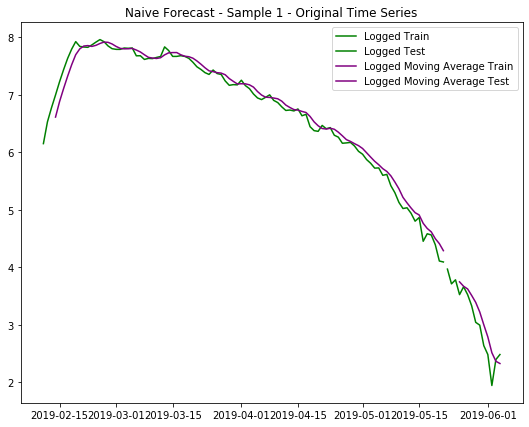

In [4]:
plt.figure(figsize=(9,7))
plt.plot(ts_log_train1.index, ts_log_train1, label='Logged Train', color='green')
plt.plot(ts_log_test1.index, ts_log_test1, label='Logged Test', color='green')
plt.plot(ts_moving_avg_train1.index, ts_moving_avg_train1, label='Logged Moving Average Train', color='purple')
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, label='Logged Moving Average Test', color='purple')
plt.legend(loc='best')
plt.title("Naive Forecast - Sample 1 - Original Time Series")
plt.show()

In [17]:
def geterate_train_test_sequences(all_ts, forecast_ts, train_period, test_period):
    """
    It divide a whole time series into multiple train-test sequences.
    
    @param all_ts: The whole time series. Its index is the date.
    @param forecast_ts: The final testing data.
    @param train_period: The number of days in the training data.
    @param test_period: The number of days in the testing data.
    @return: A dictionary where stores the index and each (train, test) pair.
    """
    seq_idx = 0
    train_test_dct = {}
    
    train_idx = 0
    
    while train_idx <= len(all_ts)-train_period-test_period:
        train_seq = all_ts[train_idx:train_idx+train_period]
        test_seq = all_ts[train_idx+train_period:train_idx+train_period+test_period]
        
        train_test_dct[seq_idx] = {'train': train_seq, 'test': test_seq}
        
        train_idx += test_period
        seq_idx += 1
        
    train_seq = all_ts[train_idx:]
    train_test_dct[seq_idx] = {'train': train_seq, 'test': forecast_ts}
        
    return train_test_dct

In [30]:
ts_log1_train_test_dct = geterate_train_test_sequences(ts_log_train1, ts_log_test1, train_period=21, test_period=7)
ts_log2_train_test_dct = geterate_train_test_sequences(ts_log_train2, ts_log_test2, train_period=21, test_period=7)
ts_ma1_train_test_dct = geterate_train_test_sequences(ts_moving_avg_train1, ts_moving_avg_test1, train_period=21, test_period=7)
ts_ma2_train_test_dct = geterate_train_test_sequences(ts_moving_avg_train2, ts_moving_avg_test2, train_period=21, test_period=7)

## Logged Time Series

In [ ]:
all_train = ts_log_train1
all_test

### Approach 1 - Holt's Linear Trend

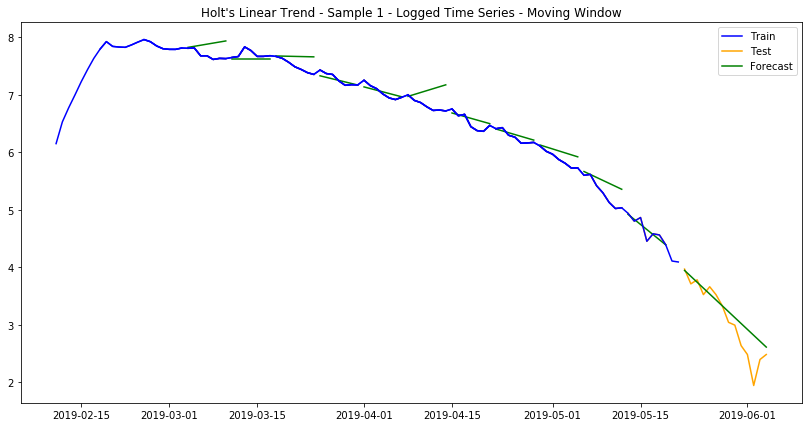

[0.2177, 0.0985, 0.195, 0.0589, 0.0658, 0.3012, 0.1133, 0.065, 0.1513, 0.2493, 0.0961, 0.308]


In [58]:
title = "Holt's Linear Trend"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_log1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = Holt(np.asarray(train)).fit(smoothing_level = 0.8)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 1 - Logged Time Series - Moving Window")
plt.show()
print(rmse_lst)